<a href="https://colab.research.google.com/github/Gabriel-Bisson/TelecomX-2/blob/main/TelecomX-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset cargado. Forma: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Columna 'customerID' eliminada.
Dataset codificado. Nueva forma: (7267, 31)

Proporción de Churn (en df original):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Top 15 correlaciones con el target:


,Churn_Yes
Churn_Yes,1.000000
internet.InternetService_Fiber optic,0.300949
account.PaymentMethod_Electronic check,0.294626
account.Charges.Monthly,0.189866
account.PaperlessBilling_Yes,0.186666
customer.SeniorCitizen,0.146733
internet.StreamingTV_Yes,0.062430
internet.StreamingMovies_Yes,0.060586
phone.MultipleLines_Yes,0.039343
phone.PhoneService_Yes,0.012571


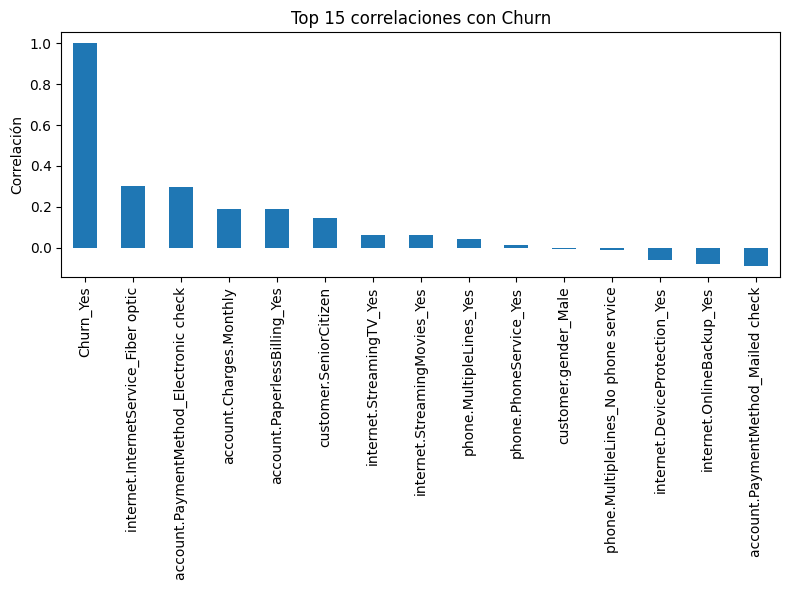

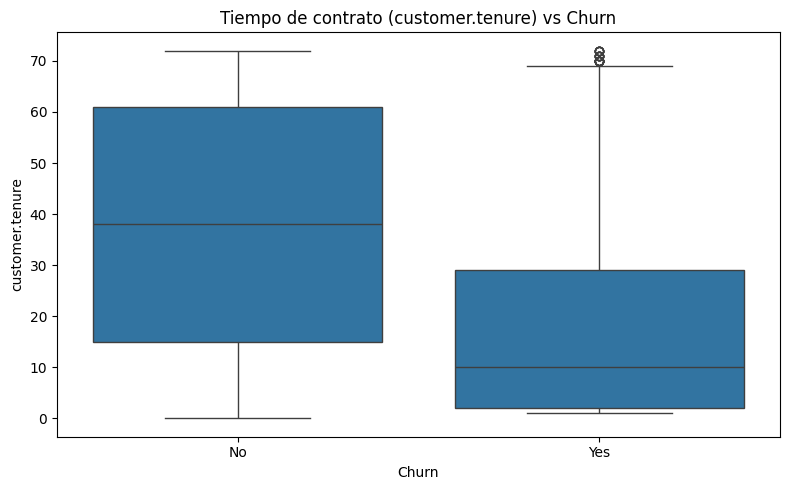

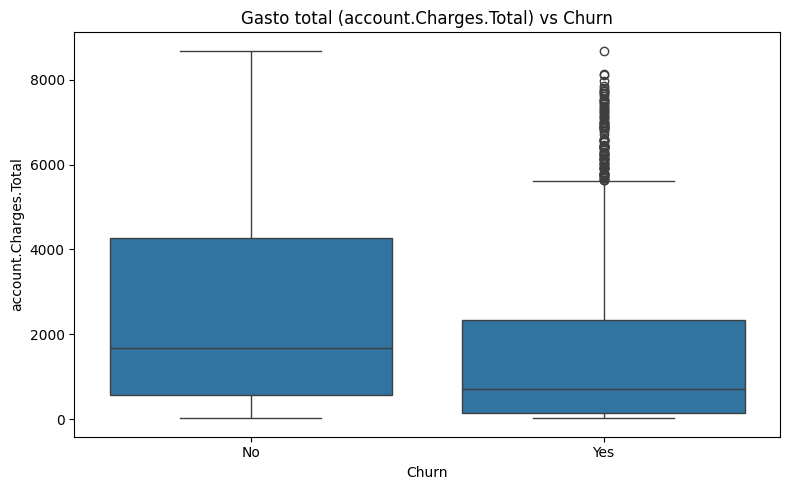

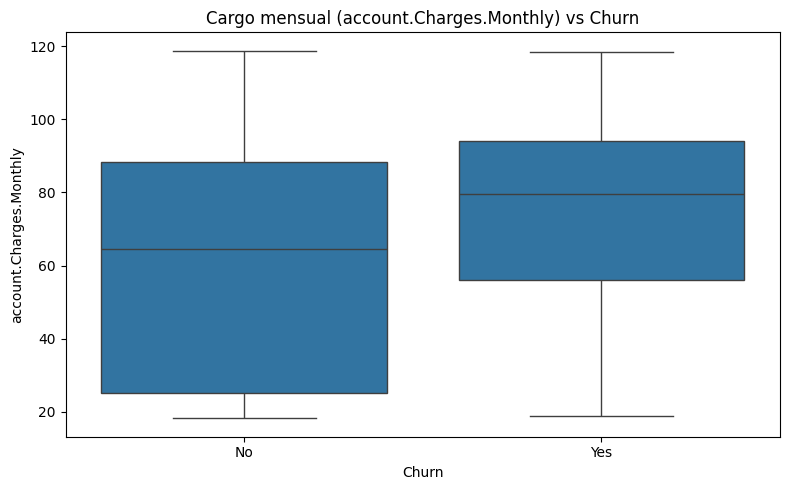


Train: (5086, 30) Test: (2181, 30)

Modelo: Regresión Logística
Accuracy: 0.8005502063273727
Precision: 0.6340425531914894
Recall: 0.5311942959001783
F1-score: 0.5780795344325897


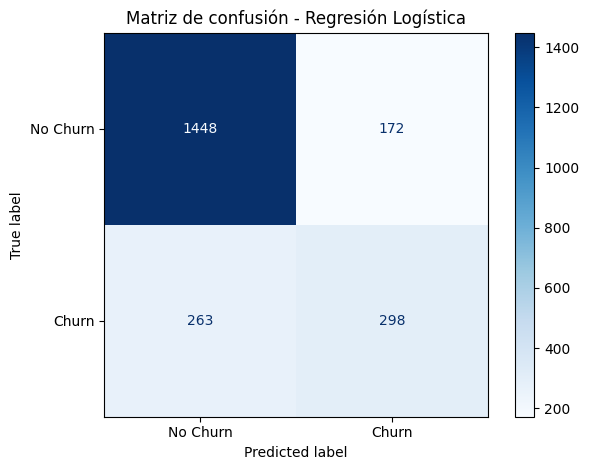


Modelo: Random Forest
Accuracy: 0.7840440165061898
Precision: 0.6004464285714286
Recall: 0.47950089126559714
F1-score: 0.533201189296333


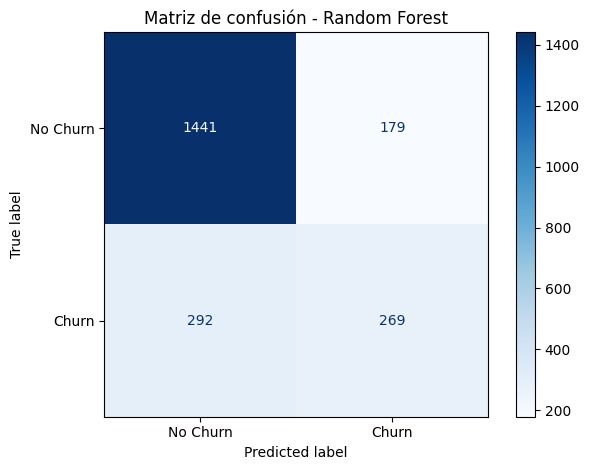

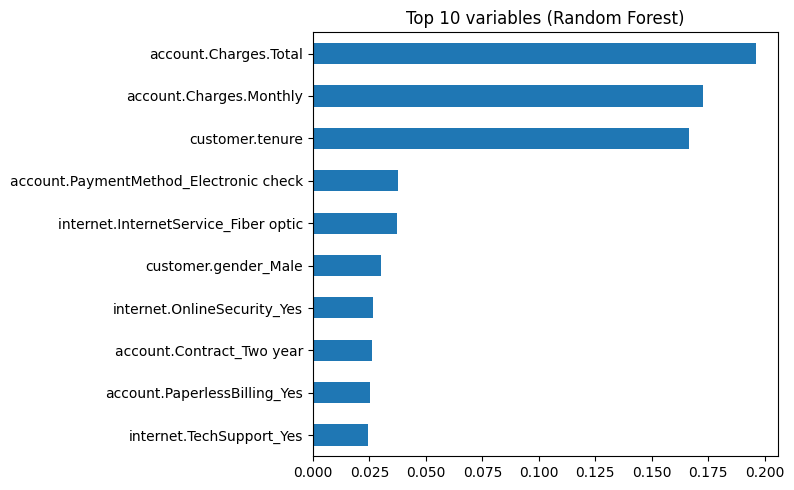

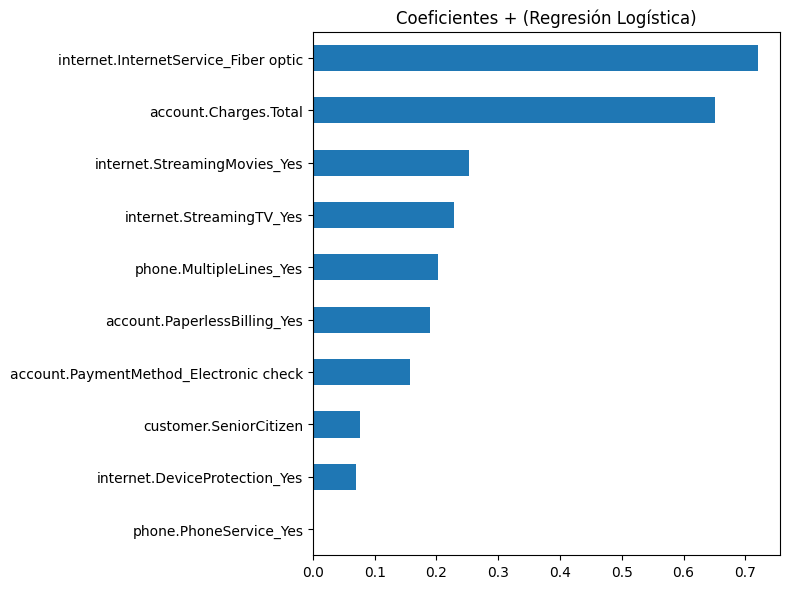

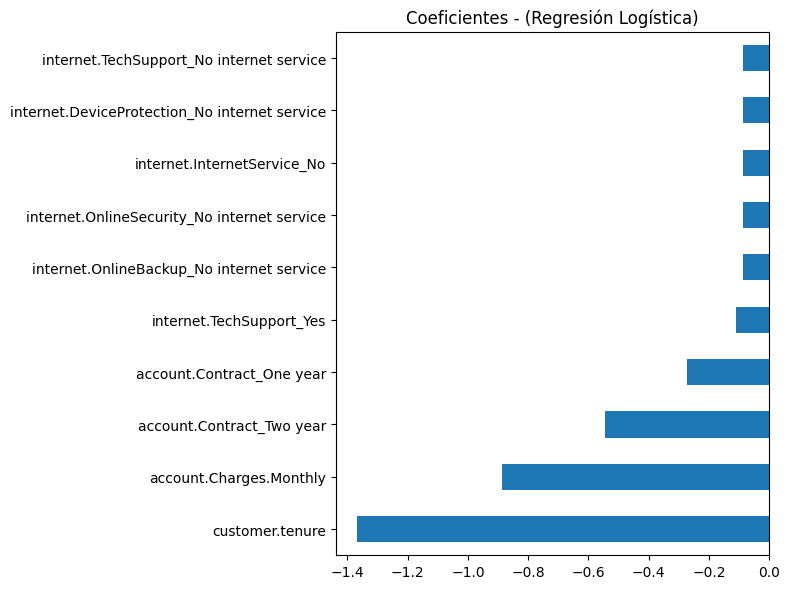


Conclusiones e Insights:
- La proporción de churn (~26%) muestra desbalance moderado.
- Variables con mayor relación al churn: revisa el Top 15 de correlaciones y las Top 10 de RF.
- Comparando métricas, indica qué modelo funcionó mejor y por qué (recall vs precision según el objetivo del negocio).
- Acciones recomendadas: ofertas para contratos mes a mes, revisión de clientes con alto cargo mensual/bajo tenure, incentivos en métodos de pago, etc.



In [1]:
# PARTE 2 - TELECOM X: Análisis Predictivo de Churn

# 0 --- Importación de las librerías ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1 --- Cargando el archivo CSV tratado al final de la Parte 1 ---

df = pd.read_csv("telecomx-Parte2.csv")
print("Dataset cargado. Forma:", df.shape)
display(df.head())

# 2 --- Eliminar columnas irrelevantes ---

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
    print("Columna 'customerID' eliminada.")

# 2.1 --- Asegurar tipos correctos ANTES del one-hot ---
# Muy importante: si 'account.Charges.Total' está como object, convertir a numérico para no crear miles de dummies
if "account.Charges.Total" in df.columns:
    df["account.Charges.Total"] = pd.to_numeric(df["account.Charges.Total"], errors="coerce")
    df["account.Charges.Total"] = df["account.Charges.Total"].fillna(df["account.Charges.Total"].median())

# 3 --- One-Hot Encoding para variables categóricas ---
df_encoded = pd.get_dummies(df, drop_first=True)
print("Dataset codificado. Nueva forma:", df_encoded.shape)

# 4 --- Verificación de proporción de cancelación ---
print("\nProporción de Churn (en df original):")
print(df["Churn"].value_counts(normalize=True).rename("proportion"))

# 5 --- Normalización (solo para modelos sensibles a escala) ---
# (Haremos el escalado solo al entrenar la Regresión Logística para evitar fugas de información)
scaler = StandardScaler()

# 6 --- Correlación con el target ---
target_candidates = [c for c in df_encoded.columns if c.startswith("Churn_")]
if len(target_candidates) == 0:
    raise ValueError("No se encontró la columna objetivo codificada. Revisa el nombre de 'Churn' en el dataset.")
target_col = target_candidates[0]

corr_with_target = df_encoded.corr(numeric_only=True)[target_col].sort_values(ascending=False)
print("\nTop 15 correlaciones con el target:")
display(corr_with_target.head(15))

plt.figure(figsize=(8,6))
corr_with_target.head(15).plot(kind="bar")
plt.title("Top 15 correlaciones con Churn")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# 7 --- Análisis dirigido (usar los nombres reales de las columnas) ---
# Tenure vs Churn
if "customer.tenure" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="Churn", y="customer.tenure", data=df)
    plt.title("Tiempo de contrato (customer.tenure) vs Churn")
    plt.tight_layout()
    plt.show()

# TotalCharges vs Churn
if "account.Charges.Total" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="Churn", y="account.Charges.Total", data=df)
    plt.title("Gasto total (account.Charges.Total) vs Churn")
    plt.tight_layout()
    plt.show()

# MonthlyCharges vs Churn
if "account.Charges.Monthly" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="Churn", y="account.Charges.Monthly", data=df)
    plt.title("Cargo mensual (account.Charges.Monthly) vs Churn")
    plt.tight_layout()
    plt.show()

# 8 --- Separación de datos ---
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("\nTrain:", X_train.shape, "Test:", X_test.shape)

# 9 --- Creación de modelos ---
# Modelo 1: Regresión Logística (con normalización)
# Escalamos después del split para evitar data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# Modelo 2: Random Forest (sin normalización)
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# 10 --- Evaluación de modelos ---
def evaluar_modelo(nombre, modelo, X_te, y_te):
    y_pred = modelo.predict(X_te)
    print(f"\nModelo: {nombre}")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred))
    print("Recall:", recall_score(y_te, y_pred))
    print("F1-score:", f1_score(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn","Churn"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.tight_layout()
    plt.show()

evaluar_modelo("Regresión Logística", model_lr, X_test_scaled, y_test)
evaluar_modelo("Random Forest", model_rf, X_test, y_test)

# 11 --- Análisis de las variables ---
# Importancia en Random Forest
feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
top_rf = feat_importances.nlargest(10)
plt.figure(figsize=(8,5))
top_rf.sort_values().plot(kind='barh')
plt.title("Top 10 variables (Random Forest)")
plt.tight_layout()
plt.show()

# Coeficientes en Regresión Logística (en el espacio escalado)
coeffs = pd.Series(model_lr.coef_[0], index=X.columns).sort_values()
plt.figure(figsize=(8,6))
coeffs.tail(10).plot(kind='barh', title="Coeficientes + (Regresión Logística)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
coeffs.head(10).plot(kind='barh', title="Coeficientes - (Regresión Logística)")
plt.tight_layout()
plt.show()

# 12 --- Conclusión final ---
print("""
Conclusiones e Insights:
- La proporción de churn (~26%) muestra desbalance moderado.
- Variables con mayor relación al churn: revisa el Top 15 de correlaciones y las Top 10 de RF.
- Comparando métricas, indica qué modelo funcionó mejor y por qué (recall vs precision según el objetivo del negocio).
- Acciones recomendadas: ofertas para contratos mes a mes, revisión de clientes con alto cargo mensual/bajo tenure, incentivos en métodos de pago, etc.
""")